In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import confusion_matrix 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from sklearn.impute import KNNImputer
import missingpy 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# First, read in the CSV file

df = pd.read_csv("COVID_data.csv", sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

## Object Oriented Programming
The following creates two classes. The Questions class contains all responses to all of the survey questions from the COVID Impact Survey. The Patient class contains relevant demographic information about each person and calls in the Questions class as well to store individual responses to each question. 

In [3]:
class Questions:
    
    # The init function
    def __init__(self, row):
        self.q = row.drop(columns=['SU_ID', 'P_PANEL', 'P_GEO', 'AGE4', 'AGE7', 'GENDER', 'RACETH', 'RACE_R2', 'HHINCOME', 'EDUCATION', 'EDUC4', 'P_OCCUPY', 'MARITAL', 'LGBT', 'HHSIZE1', 'HH01S', 'HH25S', 'HH612S', 'HH1317S', 'H180VS', 'REGION4', 'REGION9', 'P_DENSE', 'MODE', 'LANGUAGE', 'MAIL50', 'RACE1_BANNER', 'RACE2_BANNER', 'INC_BANNER', 'AGE_BANNER', 'HH_BANNER'])


In [4]:
class Patient:
        
    # The init function
    def __init__(self, row):
        self.name = row['SU_ID']
        self.age = row['AGE4']
        self.race = row['RACE1_BANNER']
        self.gender = row['GENDER']        
        self.income = row['HHINCOME']
        self.edu = row['EDUCATION']
        self.loc = row['P_GEO']
        self.size = row['HH_BANNER'] #size is household size
        self.q = Questions(row)

p = []        
        
for i in range(len(df)):
    my_patient = Patient(df.iloc[i])
    p.append(my_patient)
    #print ("My patient is {}".format(my_patient.name) + " and is {}".format(my_patient.age))

## Reformatting the Data
We will first need to reformat the data so that we can run the decision tree classifier and random forests classifier. 

In [5]:
df = df.replace('ABS', 1).replace('Amerispeak', 0).drop(columns=['RACE_R2']) # We are dropping the "RACE_R2" column as it is repeated information and is redudant

In [6]:
# This function will remove the words and only keep the number for each question response. For example, if a response is '(1) Yes' we want to keep just the '1'.

def get_number(df):
    for column in df.columns[2:]:
        for i in df[column]:
            if type(i) == str and i.startswith('('):
                df[column] = df[column].replace(i, i[1:i.index(')')])
            if type(i) == float:
                pass
    return (df)

In [7]:
get_number(df)

,SU_ID,P_PANEL,P_GEO,SOC1,SOC2A,SOC2B,SOC3A,SOC3B,SOC4A,SOC4B,...,REGION9,P_DENSE,MODE,LANGUAGE,MAIL50,RACE1_BANNER,RACE2_BANNER,INC_BANNER,AGE_BANNER,HH_BANNER
0,20002359,1,12,3,2,2,1,2,1,1,...,5,3,2,1,9,1,NaN,3,2,1
1,20003575,1,17,3,2,3,1,1,2,2,...,8,3,2,1,9,1,NaN,3,3,5
2,20003719,1,7,3,2,2,1,2,2,2,...,8,1,2,1,9,1,NaN,3,2,1
3,20004044,1,14,2,2,2,2,2,2,1,...,3,3,2,1,8,1,NaN,2,1,5
4,20004220,1,12,3,4,4,1,1,2,2,...,5,3,2,1,9,NaN,NaN,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,40010412,0,NaN,3,3,3,2,2,2,2,...,5,3,2,1,NaN,2,2,2,2,1
7501,40010413,0,1,2,2,1,2,3,2,2,...,9,3,2,1,NaN,3,3,1,3,1
7502,40010414,0,8,4,2,2,1,1,2,1,...,2,3,2,1,NaN,1,1,3,3,2
7503,40010420,0,NaN,2,5,5,1,1,2,2,...,6,3,2,1,NaN,3,3,3,3,2


In [8]:
## changing strings in column to integers 
def change_str_to_int(df, column):
    for i in df[column]:
        if i.startswith('Under'):
            df[column] = df[column].replace(i, '1')
        elif i.startswith('$10,000'):
            df[column] = df[column].replace(i, '2')
        elif i.startswith('$20,000'):
            df[column] = df[column].replace(i, '3')
        elif i.startswith('$30,000'):
            df[column] = df[column].replace(i, '4')
        elif i.startswith('$40,000'):
            df[column] = df[column].replace(i, '5')   
        elif i.startswith('$50,000'):
            df[column] = df[column].replace(i, '6')  
        elif i.startswith('$75,000'): 
            df[column] = df[column].replace(i, '7')
        elif i.startswith('$100,000'):
            df[column] = df[column].replace(i, '8') 
        elif i.startswith('$150,000'):
            df[column] = df[column].replace(i, '9')    
        elif i.startswith('DO'):
            df[column] = df[column].replace(i, '10')
        elif i.startswith('SKIPPED'):
            df[column] = df[column].replace(i, '11')
        elif i.startswith('REFUSED'):
            df[column] = df[column].replace(i, '12')
    return (df[column])

In [9]:
change_str_to_int(df, 'HHINCOME')

0       7
1       8
2       6
3       4
4       9
       ..
7500    6
7501    2
7502    7
7503    7
7504    1
Name: HHINCOME, Length: 7505, dtype: object

In [10]:
## There is missing data! So we will use the KNN Method to fill in the NaNs
for i in range(len(df)):
    num = np.random.randint(0,100)
    if num > 100:
        df[i][np.random.randint(0,4)] = float("NaN")

print(df)

         SU_ID  P_PANEL P_GEO SOC1 SOC2A SOC2B SOC3A SOC3B SOC4A SOC4B  ...  \
0     20002359        1    12    3     2     2     1     2     1     1  ...   
1     20003575        1    17    3     2     3     1     1     2     2  ...   
2     20003719        1     7    3     2     2     1     2     2     2  ...   
3     20004044        1    14    2     2     2     2     2     2     1  ...   
4     20004220        1    12    3     4     4     1     1     2     2  ...   
...        ...      ...   ...  ...   ...   ...   ...   ...   ...   ...  ...   
7500  40010412        0   NaN    3     3     3     2     2     2     2  ...   
7501  40010413        0     1    2     2     1     2     3     2     2  ...   
7502  40010414        0     8    4     2     2     1     1     2     1  ...   
7503  40010420        0   NaN    2     5     5     1     1     2     2  ...   
7504  40010422        0   NaN    3     2     1     1     1     2     1  ...   

     REGION9 P_DENSE MODE LANGUAGE MAIL50 RACE1_BAN

In [11]:
imputer = missingpy.MissForest()
all_data = imputer.fit_transform(df)

### Now there are no more NaNs!
print(all_data)

Iteration: 0
Iteration: 1
Iteration: 2
[[2.0002359e+07 1.0000000e+00 1.2000000e+01 ... 3.0000000e+00
  2.0000000e+00 1.0000000e+00]
 [2.0003575e+07 1.0000000e+00 1.7000000e+01 ... 3.0000000e+00
  3.0000000e+00 5.0000000e+00]
 [2.0003719e+07 1.0000000e+00 7.0000000e+00 ... 3.0000000e+00
  2.0000000e+00 1.0000000e+00]
 ...
 [4.0010414e+07 0.0000000e+00 8.0000000e+00 ... 3.0000000e+00
  3.0000000e+00 2.0000000e+00]
 [4.0010420e+07 0.0000000e+00 3.0000000e+00 ... 3.0000000e+00
  3.0000000e+00 2.0000000e+00]
 [4.0010422e+07 0.0000000e+00 2.0000000e+00 ... 1.0000000e+00
  2.0000000e+00 2.0000000e+00]]


In [12]:
## change numpy array to dataframe <- it will make things much easier when using the Decision Tree and Random Forests Classifiers

df = pd.DataFrame(data=all_data, index=df.index, columns=df.columns)

## Decision Tree Classifier

The following code will be useful for splitting the data, training the model, and outputting accuracy and other splitting measures. 

In [13]:
# This function will split the dataset into train and test using an 80/20 split
def splitdataset(df, illness = 'SOC5A'): 
  
    # Separating the target variable 
    X = df.drop(columns =['SOC5A', 'SOC5B', 'SOC5C', 'SOC5D', 'SOC5E']).values
    y = df[illness].values
    
    # The variable X contains everything but responses to the question on mental health
    # The variable Y is the target variable, responses on anxiety levels

    # Splitting the dataset into train and test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234) 
    
    # Splitting the dataset in a ratio of 80:20 between training and testing 
    # random_state variable = pseudo-random # generator used for random sampling
    
    return X, y, X_train, X_test, y_train, y_test 

In [14]:
# Call function
X, y, X_train, X_test, y_train, y_test = splitdataset(df, 'SOC5B') 
# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(random_state=1234, max_depth=2)
model = clf.fit(X, y)

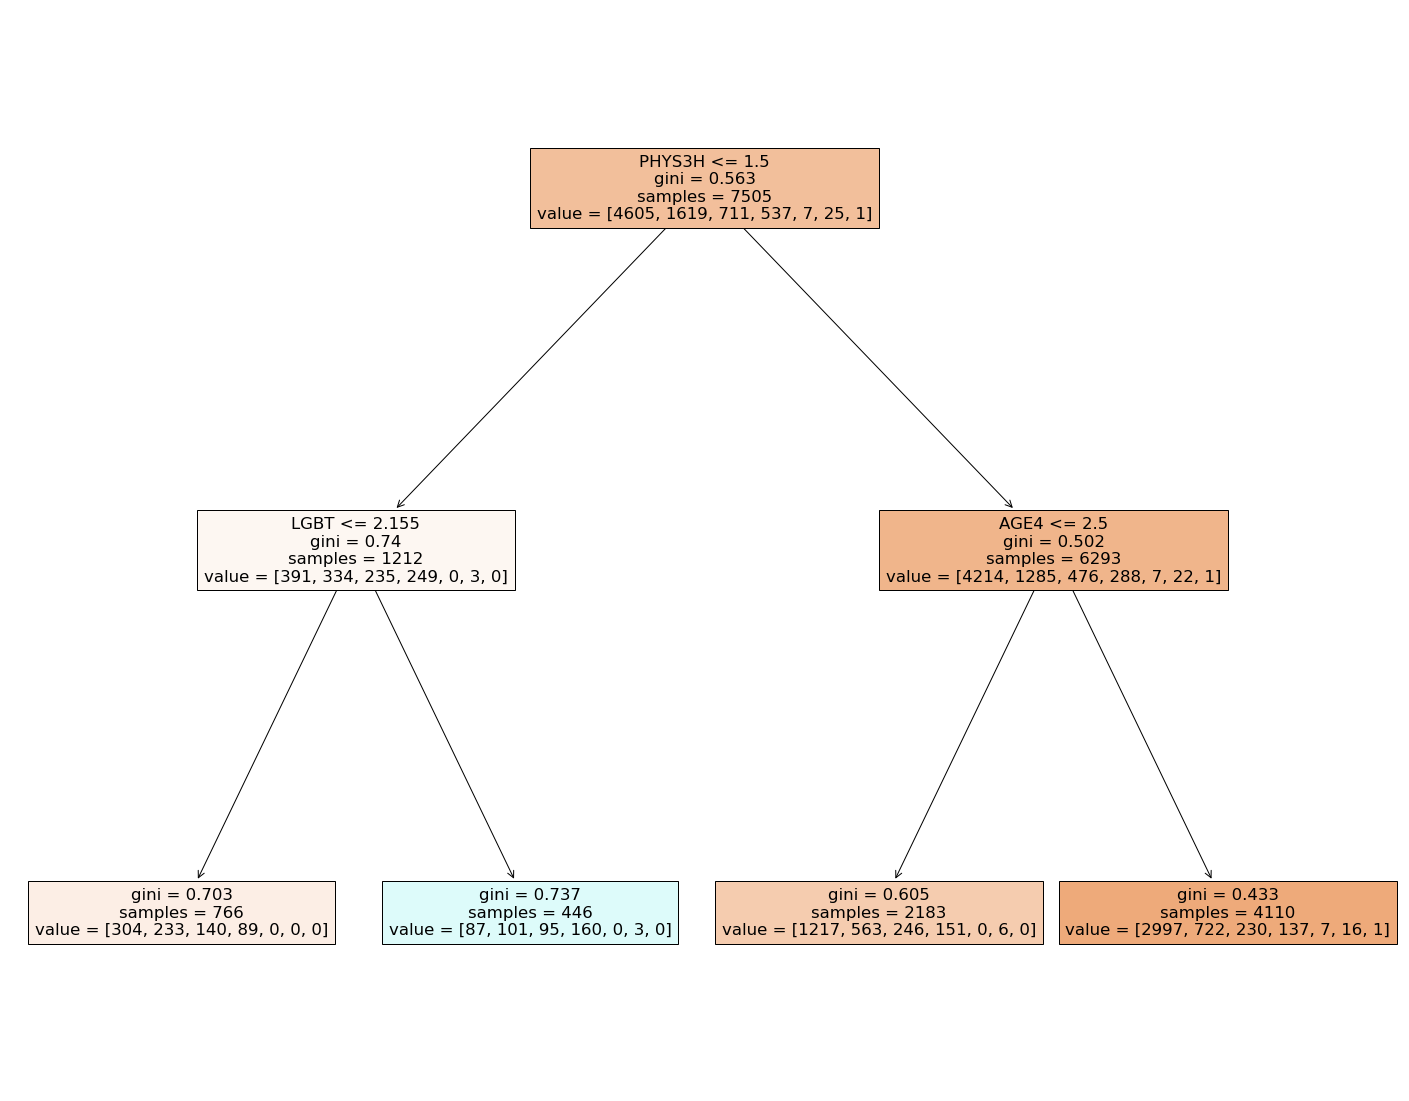

In [15]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=df.columns.drop(['SOC5A', 'SOC5B', 'SOC5C', 'SOC5D', 'SOC5E']),  
                   filled=True)

In [ ]:
fig.savefig("decistion_tree.png")

In [ ]:
classifier = DecisionTreeClassifier(random_state=1234)
classifier.fit(X_train, y_train) # trains algorithm on training data 

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# Function to perform training with giniIndex. 
def train_using_gini(X_train, X_test, y_train): 
  
    # Creating the classifier object 
    clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 100,max_depth=3, min_samples_leaf=5) 
  
    # Performing training 
    clf_gini.fit(X_train, y_train) 
    return clf_gini 

In [ ]:
# Function to perform training with entropy. 
def train_using_entropy(X_train, X_test, y_train): 
  
    # Decision tree with entropy 
    clf_entropy = DecisionTreeClassifier( 
            criterion = "entropy", random_state = 100, 
            max_depth = 3, min_samples_leaf = 5) 
  
    # Performing training 
    clf_entropy.fit(X_train, y_train) 
    return clf_entropy 

In [ ]:
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test) 
    print("Predicted values:") 
    print(y_pred) 
    return y_pred

In [ ]:
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred))

In [ ]:
# Building Phase 
clf_gini = train_using_gini(X_train, X_test, y_train) 
clf_entropy = train_using_entropy(X_train, X_test, y_train) 

# Operational Phase 
print("Results Using Gini Index:") 

# Prediction using gini 
y_pred_gini = prediction(X_test, clf_gini) 
cal_accuracy(y_test, y_pred_gini) 

print("Results Using Entropy:") 
# Prediction using entropy 
y_pred_entropy = prediction(X_test, clf_entropy) 
cal_accuracy(y_test, y_pred_entropy) 


## Random Forests Classifier

The following will be used to train the model, output the accuracy of the model, and determine feature importance.

In [16]:
# Feature Scaling (Normalizing Data)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [17]:
## This line instantiates the model. 
rf = RandomForestClassifier(n_estimators=64) 
## Fits the model on my training data.
rf.fit(X_train, y_train) 
## And scores it on my testing data.
y_pred=rf.predict(X_test)

In [18]:
#Model Accuracy, how often is the classifier correct?

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6102598267821452


In [19]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.610


In [20]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[878  12   0   2   0   0]
 [307  25   2   2   0   0]
 [125  10   4   5   0   0]
 [ 92  12   2   9   0   0]
 [  2   0   0   0   0   0]
 [ 12   0   0   0   0   0]]
              precision    recall  f1-score   support

         1.0       0.62      0.98      0.76       892
         2.0       0.42      0.07      0.13       336
         3.0       0.50      0.03      0.05       144
         4.0       0.50      0.08      0.14       115
        77.0       0.00      0.00      0.00         2
        98.0       0.00      0.00      0.00        12

    accuracy                           0.61      1501
   macro avg       0.34      0.19      0.18      1501
weighted avg       0.55      0.61      0.50      1501



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
forest = ExtraTreesClassifier(n_estimators=64,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [22]:
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 147 (0.015099)
2. feature 146 (0.014771)
3. feature 139 (0.012984)
4. feature 138 (0.012711)
5. feature 129 (0.012507)
6. feature 145 (0.011246)
7. feature 10 (0.011018)
8. feature 0 (0.010146)
9. feature 2 (0.009967)
10. feature 142 (0.009802)
11. feature 4 (0.009691)
12. feature 143 (0.009688)
13. feature 155 (0.009681)
14. feature 52 (0.009616)
15. feature 87 (0.009503)
16. feature 50 (0.009398)
17. feature 51 (0.009272)
18. feature 53 (0.009263)
19. feature 89 (0.009160)
20. feature 5 (0.009140)
21. feature 86 (0.009006)
22. feature 154 (0.008995)
23. feature 164 (0.008991)
24. feature 113 (0.008976)
25. feature 54 (0.008947)
26. feature 162 (0.008931)
27. feature 159 (0.008881)
28. feature 88 (0.008652)
29. feature 140 (0.008632)
30. feature 7 (0.008563)
31. feature 55 (0.008506)
32. feature 90 (0.008484)
33. feature 153 (0.008458)
34. feature 3 (0.008420)
35. feature 148 (0.008353)
36. feature 73 (0.008208)
37. feature 72 (0.008002)
38. feature 128 (0.

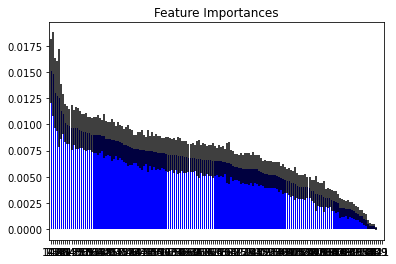

In [23]:
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

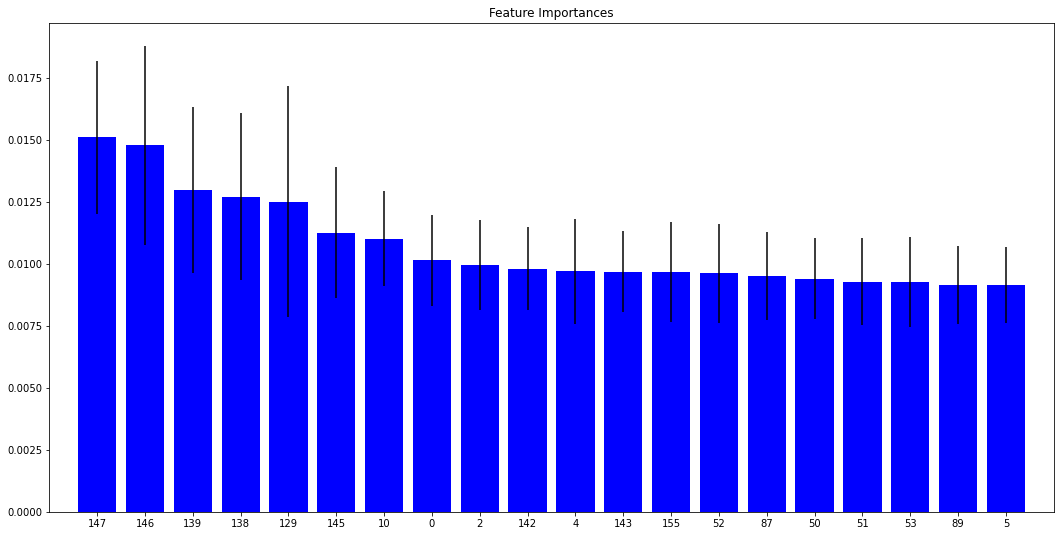

In [24]:
plt.figure(figsize=(18,9))
plt.title("Feature Importances")
n=20
_ = plt.bar(range(n), importances[indices][:n], color="b", yerr=std[indices][:n])
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

In [25]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [26]:
## This function is used to determine permutation feature importance!

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

In [27]:
pd.set_option('display.max_rows', None)
perm_imp_rfpimp

,Importance
Feature,
147,0.275353
146,0.180182
145,0.111707
129,0.072614
140,0.068417
139,0.000883
33,0.000420
138,0.000275
72,0.000210
